In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import scipy.stats as st
import os
import json

import optuna
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

c:\Users\sofia\anaconda3\envs\mi_entorno310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import sys
sys.path.append('../scr')

from utils_clean import filtrar_ub_semanal, imputar_nulos_semanal, estacionarizar_arima, partir_train_test
from utils_data import downloadTable
from utils_model import buscar_hiperparametros_arima_sarima, buscar_hiperparametros_arima_semanal
from utils_metrics import errorMetrics

# Importar Data

In [7]:
queryPrices = """
SELECT * FROM `desarrollo-444913.globalPrices.prices`
"""
# Usar forceDownload=True para actualizar la tabla
df = downloadTable(queryPrices,"globalPricesTable",forceDownload=False)

Folder 'bigqueryDatabases' already exists.
Reading bigqueryDatabases\globalPricesTable.csv from local CSV.


In [8]:
df.head()

,date,price,priceId,priceName,currency,currencyId,priceType,source
0,2022-10-01,14.637188,4,Japan Frozen Atlantic TRIM-E,USD,0,EXPORT,CHILEAN EXPORTS
1,2023-03-01,12.265160,5,Japan Fresh Atlantic TRIM-A,USD,0,EXPORT,CHILEAN EXPORTS
2,2024-02-01,5.859417,1,Japan Frozen Coho HG,USD,0,EXPORT,CHILEAN EXPORTS
3,2012-11-08,6.724091,11,UB Atlantic TRIM-D 3-4 Lb FOB Miami,USD,0,EXPORTS,URNER BARRY
4,2007-12-26,7.495708,11,UB Atlantic TRIM-D 3-4 Lb FOB Miami,USD,0,EXPORTS,URNER BARRY


In [9]:
#  Crear la serie semanal
serie = filtrar_ub_semanal(df)

In [10]:
# 2) Imputar esos NaN con interpolación lineal
df_semanal, flags = imputar_nulos_semanal(
    serie, metodo="interpolate", devolver_flags=True
)

In [11]:
df_semanal

date
2007-01-08     9.038942
2007-01-15     9.038942
2007-01-22     9.204289
2007-01-29     9.369635
2007-02-05     9.479866
                ...    
2025-05-12    14.054452
2025-05-19    13.393066
2025-05-26    13.007258
2025-06-02    12.566334
2025-06-09    12.235641
Freq: W-MON, Name: price, Length: 962, dtype: float64

# Visualización

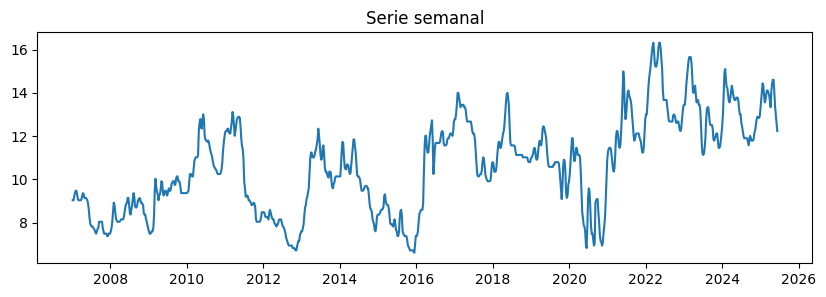

In [12]:
plt.figure(figsize=(10,3))
plt.plot(df_semanal)
plt.title("Serie semanal")
plt.show()

## Estacionariedad

In [13]:

serie = df_semanal.copy()

adf_res = adfuller(serie)

adf_stat      = adf_res[0]   # Estadístico ADF
adf_p         = adf_res[1]   # p-value
adf_lags      = adf_res[2]   # Lags usados
adf_n         = adf_res[3]   # Nº observaciones
adf_crit_vals = adf_res[4]   # Valores críticos

print("=== Prueba ADF ===")
print(f"H₀: la serie NO es estacionaria (tiene raíz unitaria)\n")
print(f"Estadístico : {adf_stat:.4f}")
print(f"p-value     : {adf_p:.4f}")
print(f"Lags usados : {adf_lags}")
print("Valores críticos:", adf_crit_vals)

#a un 5 % de significancia, la serie no presenta raíz unitaria y se puede tratar como estacionaria

=== Prueba ADF ===
H₀: la serie NO es estacionaria (tiene raíz unitaria)

Estadístico : -3.0619
p-value     : 0.0295
Lags usados : 2
Valores críticos: {'1%': np.float64(-3.43718721587049), '5%': np.float64(-2.8645585177815187), '10%': np.float64(-2.568377225331392)}


In [14]:
# --- . Prueba KPSS ---
kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(serie, nlags="auto")
print("\n=== Prueba KPSS ===")
print(f"Estadístico : {kpss_stat:.4f}")
print(f"p-value     : {kpss_p:.4f}")
print(f"Lags usados : {kpss_lags}")
print("Valores críticos:", kpss_crit)



if kpss_p > 0.05:
    print("KPSS indica: estacionaria.")
else:
    print("KPSS indica: NO estacionaria.")


=== Prueba KPSS ===
Estadístico : 2.2131
p-value     : 0.0100
Lags usados : 19
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS indica: NO estacionaria.


In [15]:
# al tener los datos en mensual se había suavizado el ruido por eso es no estacionaria semanalmente
# Estacionarizamos
serie_estacionaria, d_optimo = estacionarizar_arima(df_semanal)


Serie estacionaria con d = 1


## ACF y PACF

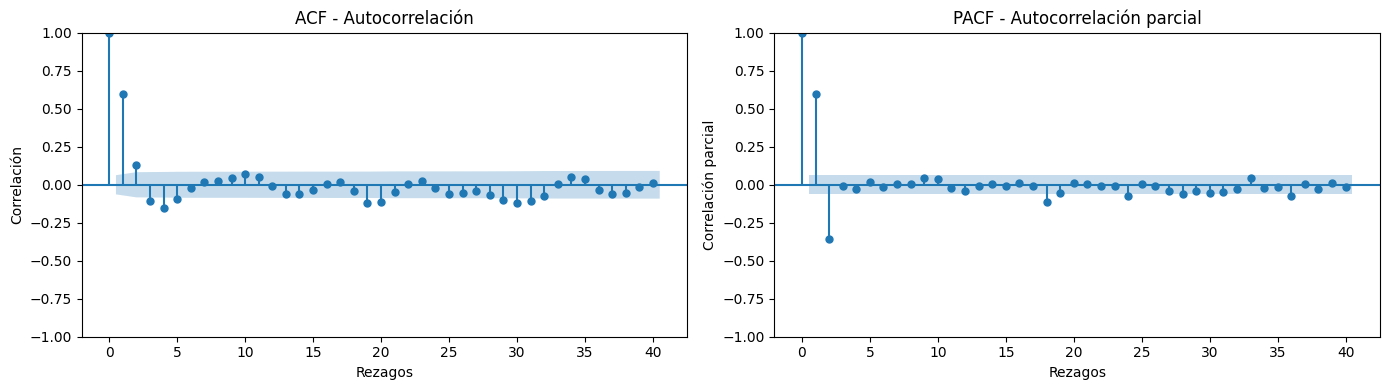

In [16]:
# usaremos la serie_estacionaria
serie_plot = serie_estacionaria

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF (para q)
plot_acf(serie_plot, lags=40, ax=axes[0])
axes[0].set_title("ACF - Autocorrelación")
axes[0].set_xlabel("Rezagos")
axes[0].set_ylabel("Correlación")

# PACF (para p)
plot_pacf(serie_plot, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF - Autocorrelación parcial")
axes[1].set_xlabel("Rezagos")
axes[1].set_ylabel("Correlación parcial")

plt.tight_layout()
plt.show()


# Modelo

In [17]:
# Vamos a usar hasta 2023 y testear en 2024
df_semanal = df_semanal.sort_index()
train = df_semanal.loc[:'2023-12-01']   # Ajusta el string según tu índice
test = df_semanal.loc['2024-01-01':'2024-12-01']

In [18]:
# Mejores hiperparametros
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(train, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=422.187, Time=0.31 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=39.826, Time=0.66 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2.603, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=420.258, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=0.661, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2.607, Time=0.78 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2.327, Time=2.51 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-53.808, Time=0.34 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-51.954, Time=0.85 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-51.964, Time=0.89 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-51.890, Time=2.43 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=38.013, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-76.828, Time=0.35 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-75.053, Time=1.40 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=

In [20]:

# Buscar el mejor modelo ARIMA con AIC
modelo, order, resumen = buscar_hiperparametros_arima_semanal(
    serie=train,
    max_p=3, max_d=2, max_q=3,
    criterio='aic',
    trace=True
)

print(resumen)          
print("Mejores (p, d, q):", order)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=422.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.013, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=0.661, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=420.258, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53.808, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-76.828, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.695, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-76.817, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-74.700, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-80.663, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.024, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-78.783, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-78.794, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-55.789, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-76.667, 

In [22]:
order

(2, 1, 0)

In [ ]:
# ROLLING PREDICTIONS


# --- CONFIGURA TUS PARÁMETROS MANUALMENTE ---
order = (1, 1, 2)  # Reemplaza por tus valores encontrados
seasonal_order = (1, 0, 1, 52)  # Estacionalidad semanal (m=52)
horizonte = 1  # Predicción de 1 paso cada vez

# --- PREPARA LAS SERIES ---
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-30', freq='W-MON')  # Fechas lunes de cada semana

# --- ROLLING PREDICTION ---
for fecha in fechas_pred:
    modelo = ARIMA(serie_rolling, order=order, seasonal_order=seasonal_order)
    fitted = modelo.fit()
    pred = fitted.forecast(steps=1)[0]
    predicciones.append(pred)

    if fecha in df_semanal.index:
        valor_a_agregar = df_semanal.loc[fecha]
    else:
        valor_a_agregar = pred

    serie_rolling = pd.concat([serie_rolling, pd.Series([valor_a_agregar], index=[fecha])])

# --- GUARDAR LOG ---
date = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
dir_checkpoint = f"""results/ARIMA_{order[0]}_{order[1]}_{order[2]}_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}_{date}/"""

if not os.path.exists(dir_checkpoint):
    os.makedirs(dir_checkpoint)

logDict = {
    "p": order[0],
    "d": order[1],
    "q": order[2],
    "P": seasonal_order[0],
    "D": seasonal_order[1],
    "Q": seasonal_order[2],
    "M": seasonal_order[3],
    "Horizonte": horizonte,
    "Rolling": "Semanal 2024"
}

with open(dir_checkpoint + 'log.json', 'w') as f:
    json.dump(logDict, f, indent=4)

# --- OPCIONAL: GUARDAR PREDICCIONES ---
pred_df = pd.DataFrame({
    'fecha': fechas_pred,
    'predicho': predicciones
})
pred_df.to_csv(dir_checkpoint + 'predicciones.csv', index=False)


# Métricas